# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token: 

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen. 

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation** 

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer
import warnings
warnings.filterwarnings("ignore", message="enable_nested_tensor is True")

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")

Dispositivo:  cpu
Torch version:  2.7.0+cu126


# Transformer Encoder

In [2]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True, bias=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
> 
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [3]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int, num_classes: int, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout: float = 0.1, batch_first: bool =True):
        
        super(VisionTransformer, self).__init__()
        # Patch Embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        # Token de clase
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional encoding aprendido
        self.pos_embed = PositionalEncodingLearned(num_patches + 1, embed_dim)
        # Transformer
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout, batch_first)
        # Capa de clasificación final
        self.head = nn.Linear(embed_dim, num_classes)
        # Inicialización de pesos
        self.init_weights()

    def init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)
        # Extraigo y proyecto parches
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        # Agrego el token de clase
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, embed_dim)
        # Agrego posicional embedding
        x = self.pos_embed(x)
        # Encoder transformer
        x = self.encoder(x)
        # Clasificación con el token de clase (primero de la secuencia)
        cls_output = x[:, 0]  # (B, embed_dim)
        return self.head(cls_output)  # (B, num_classes)


# CIFAR10

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

In [ ]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

# Modelo

Probaremos 3 configuraciones de modelos:

In [4]:
model_configs = [
    {
    "name": "vit-small",
    "params":{
        "img_size": 32, 
        "patch_size": 4, 
        "embed_dim": 64,
        "num_heads": 2, 
        "ff_dim": 128, 
        "num_layers": 4,
        "dropout": 0.1
        }
    },
    {
    "name": "vit-mid",
    "params": {
        "img_size": 32, 
        "patch_size": 4, 
        "embed_dim": 128,
        "num_heads": 4, 
        "ff_dim": 256, 
        "num_layers": 6,
        "dropout": 0.1
        }
    },
    {
    "name": "vit-large",
    "params": {
        "img_size": 32,
        "patch_size": 4,       
        "embed_dim": 256,      
        "num_heads": 8,        
        "ff_dim": 512,        
        "num_layers": 8, 
        "dropout": 0.1
    }
}
]


Probamos dos combinaciones de aumento de datos:

In [5]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

aug_configs = {
    "aug-light": transforms.Compose([transforms.RandomHorizontalFlip(), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std),
    ]),
    "aug-strong": transforms.Compose([transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
                                      transforms.ColorJitter(0.2, 0.2, 0.2),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std),
    ])
}

Definición de funciones auxiliares

In [6]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

In [7]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

In [8]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

Entrenamiento de las diferentes configuraciones


Entrenando vit-small con aug-light


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 0.14 millones
Epoch 1/10


val_loss 1.47034: 100%|██████████| 79/79 [00:13<00:00,  5.94it/s]


Epoch 2/10


val_loss 1.23461: 100%|██████████| 79/79 [00:14<00:00,  5.52it/s]


Epoch 3/10


val_loss 1.30899: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 4/10


val_loss 1.28219: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


Epoch 5/10


val_loss 1.22899: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Epoch 6/10


val_loss 1.11304: 100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Epoch 7/10


val_loss 1.28584: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


Epoch 8/10


val_loss 1.03536: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]


Epoch 9/10


val_loss 1.06619: 100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


Epoch 10/10


100%|██████████| 79/79 [00:12<00:00,  6.45it/s]
/tmp/ipykernel_11337/2333856528.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


- Accuracy: 0.56 
- Precision: 0.57 
- Recall: 0.56 
- F1-Score: 0.56
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-small_aug-light.png


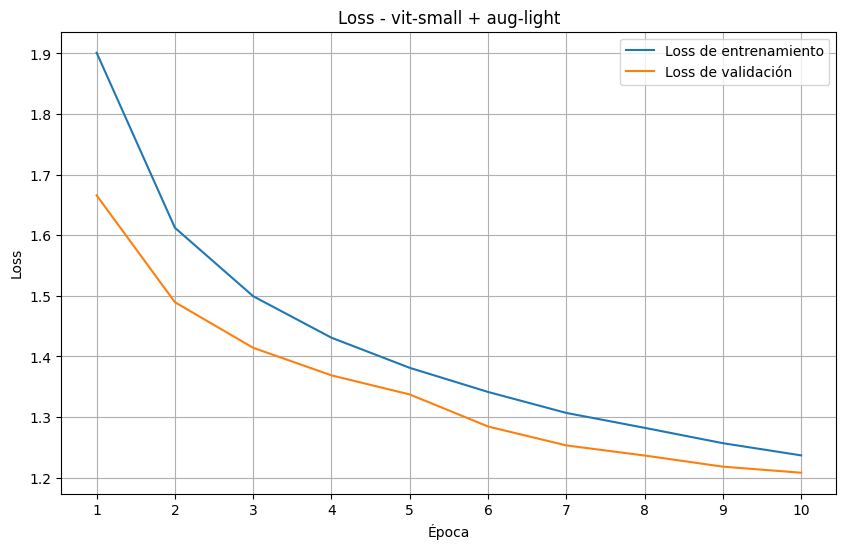

  0%|          | 0/79 [00:00<?, ?it/s]


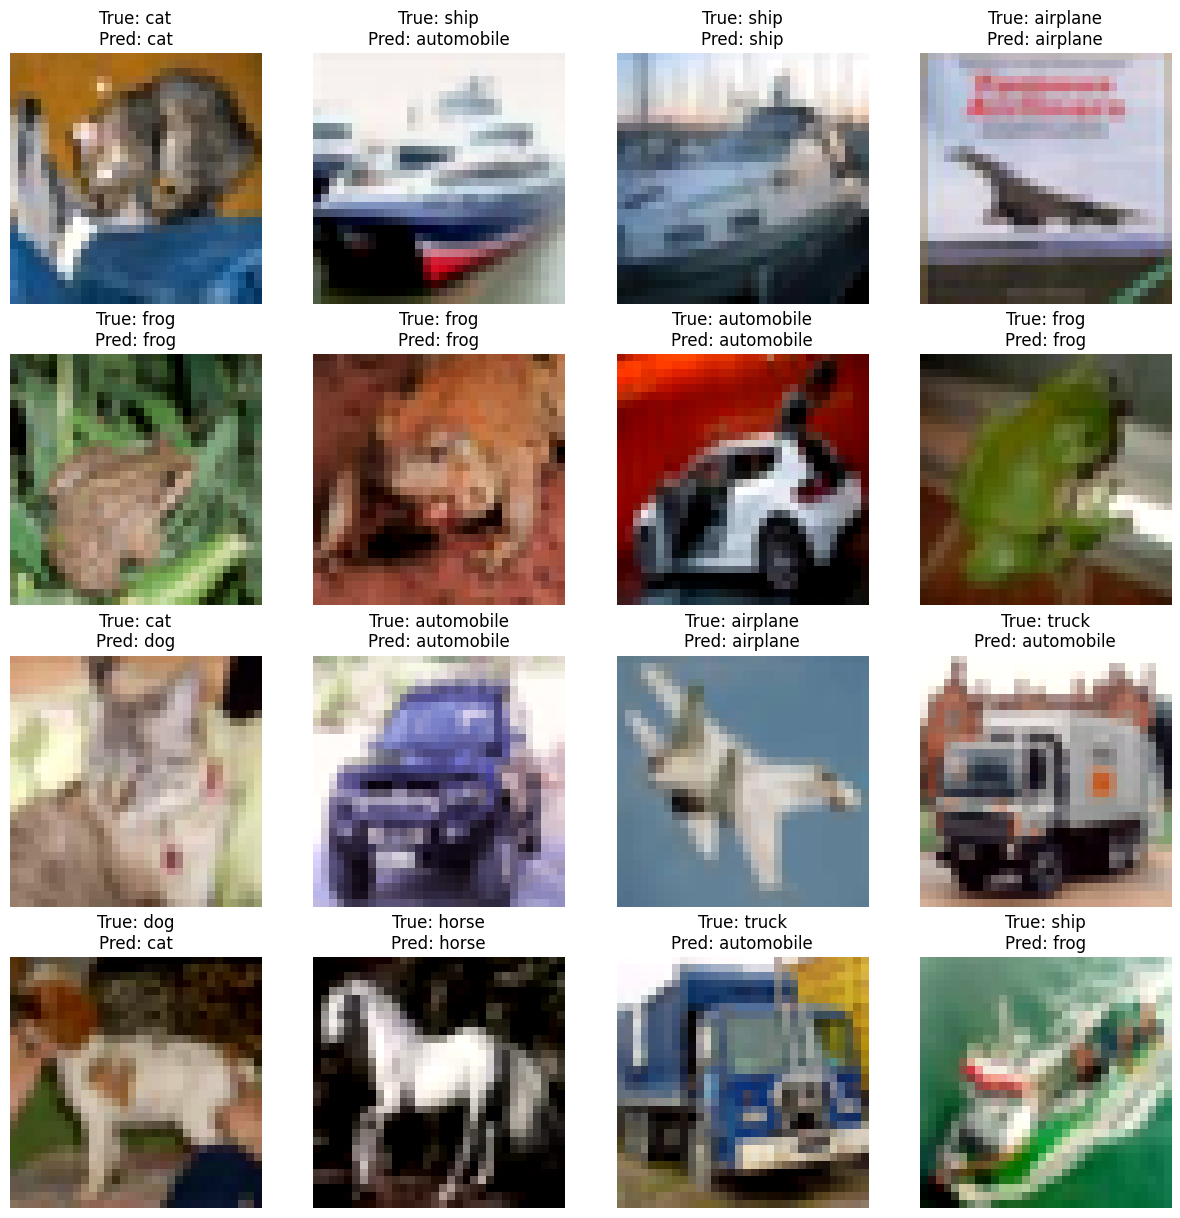


Entrenando vit-small con aug-strong


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 0.14 millones
Epoch 1/10


val_loss 1.54689: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


Epoch 2/10


val_loss 1.28311: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


Epoch 3/10


val_loss 1.15573: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


Epoch 4/10


val_loss 1.18239: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Epoch 5/10


val_loss 1.14890: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


Epoch 6/10


val_loss 1.26926: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Epoch 7/10


val_loss 1.19689: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


Epoch 8/10


val_loss 1.40577: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Epoch 9/10


val_loss 1.14905: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Epoch 10/10


100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


- Accuracy: 0.54 
- Precision: 0.54 
- Recall: 0.54 
- F1-Score: 0.54
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-small_aug-strong.png


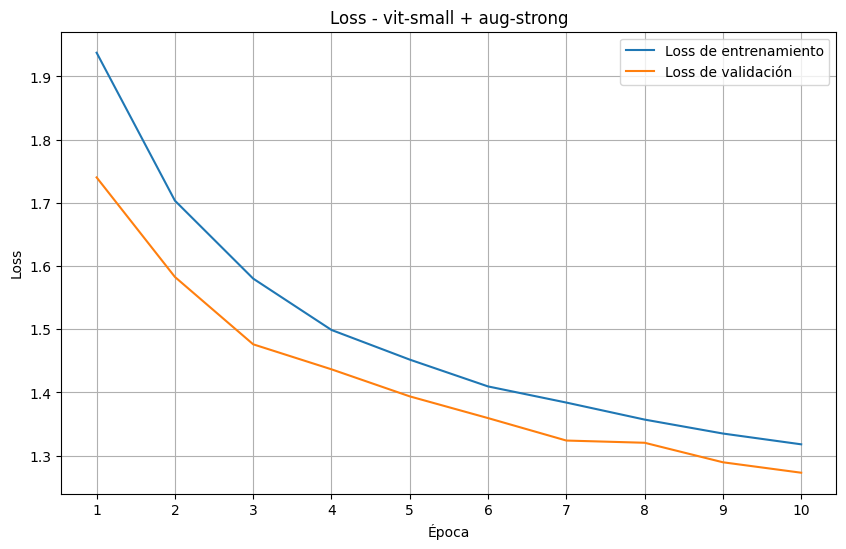

  0%|          | 0/79 [00:00<?, ?it/s]


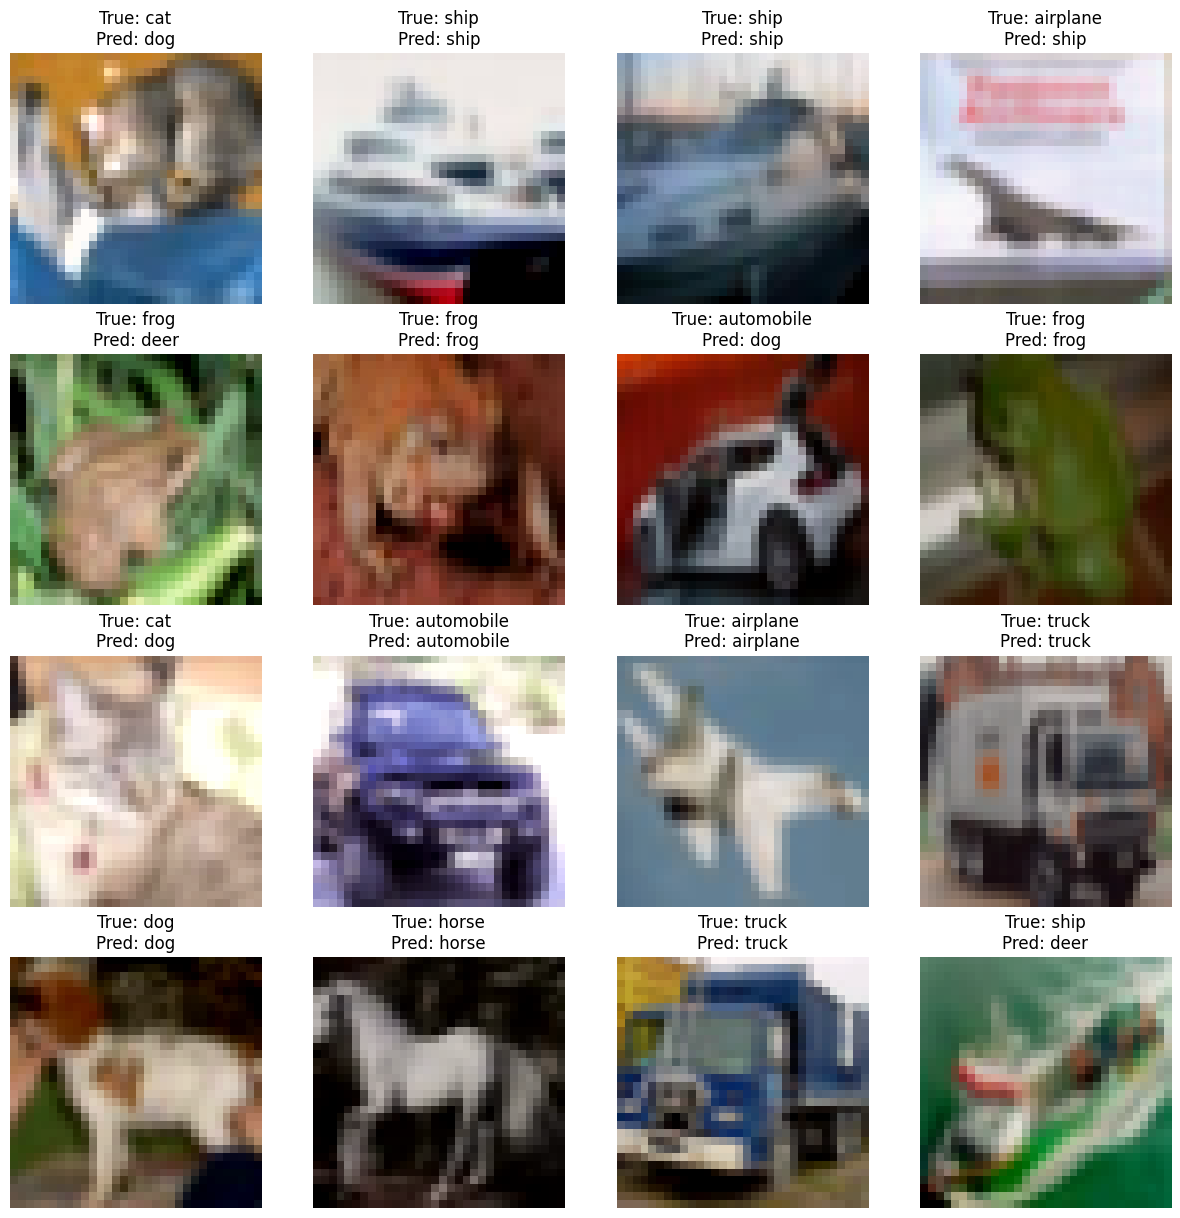


Entrenando vit-mid con aug-light


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 0.80 millones
Epoch 1/10


val_loss 1.39198: 100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 2/10


val_loss 1.20574: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 3/10


val_loss 1.13606: 100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


Epoch 4/10


val_loss 1.24013: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Epoch 5/10


val_loss 1.19770: 100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


Epoch 6/10


val_loss 1.25163: 100%|██████████| 79/79 [00:35<00:00,  2.21it/s]


Epoch 7/10


val_loss 1.22850: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Epoch 8/10


val_loss 1.02569: 100%|██████████| 79/79 [00:32<00:00,  2.45it/s]


Epoch 9/10


val_loss 1.15752: 100%|██████████| 79/79 [00:31<00:00,  2.52it/s]


Epoch 10/10


100%|██████████| 79/79 [00:31<00:00,  2.51it/s]


- Accuracy: 0.63 
- Precision: 0.63 
- Recall: 0.63 
- F1-Score: 0.63
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-mid_aug-light.png


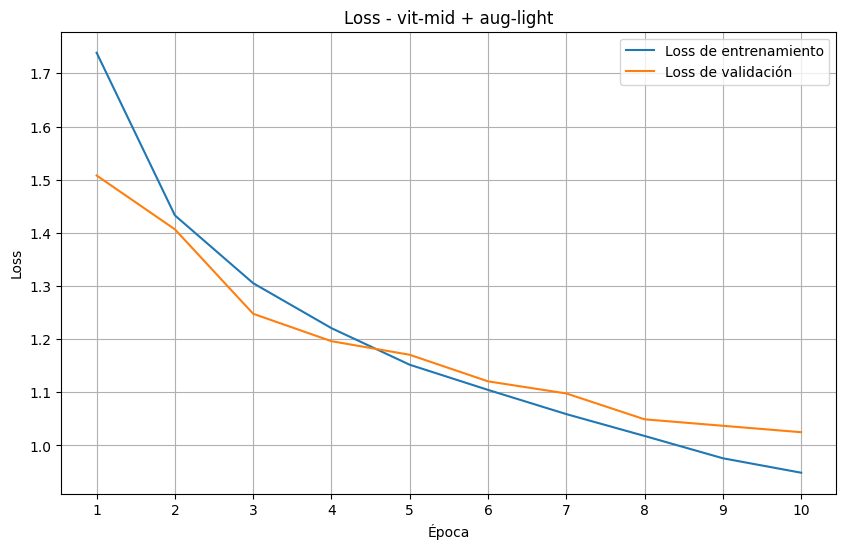

  0%|          | 0/79 [00:00<?, ?it/s]


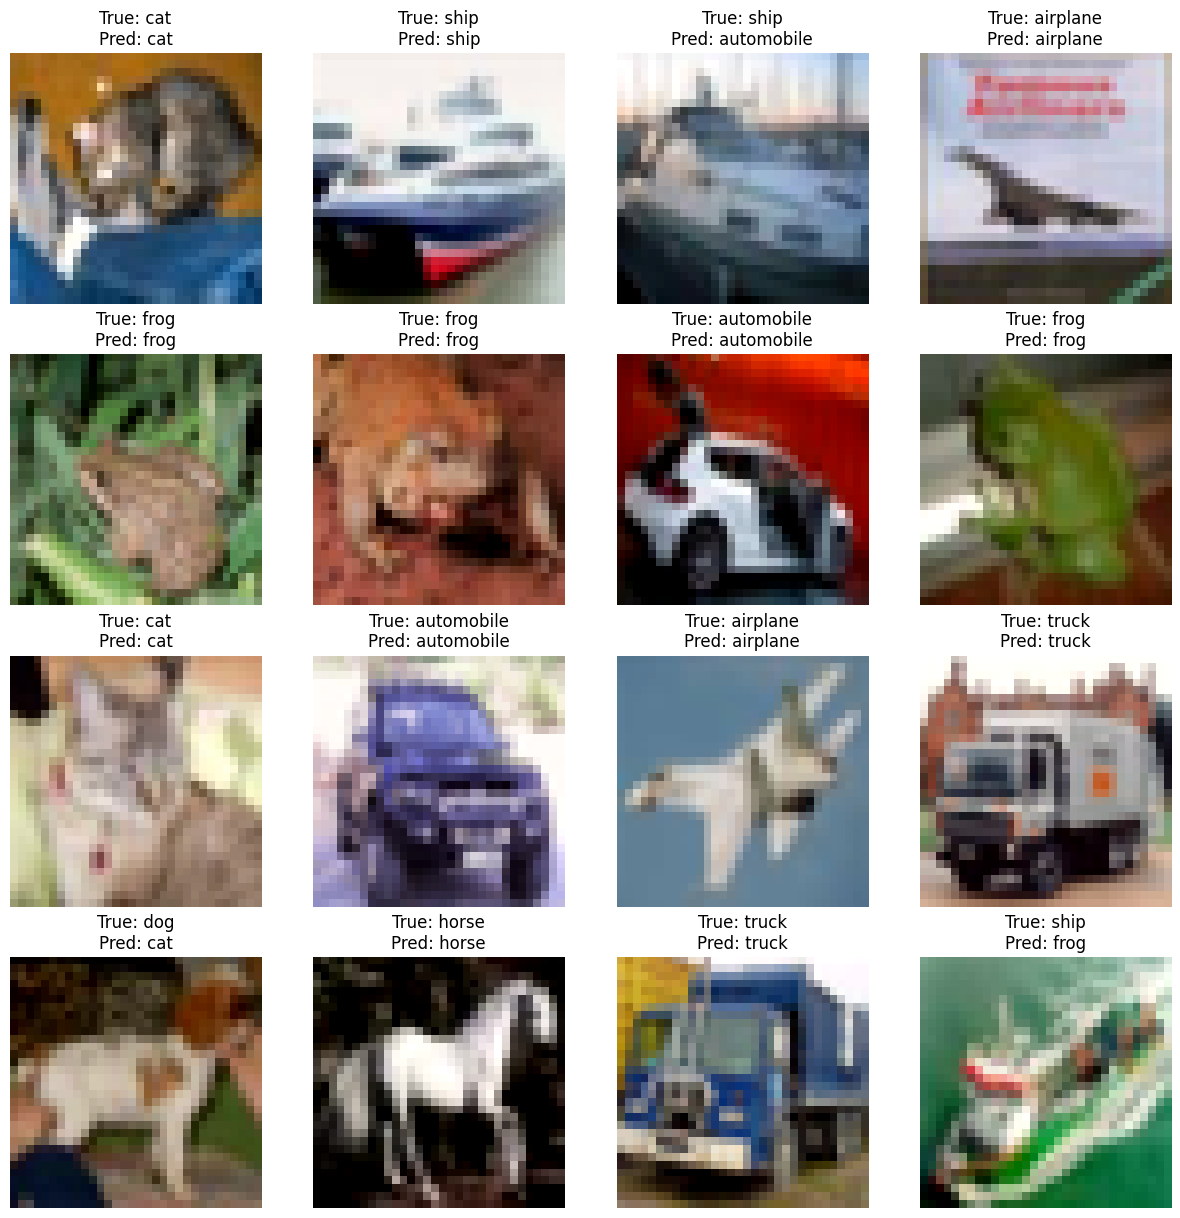


Entrenando vit-mid con aug-strong


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 0.80 millones
Epoch 1/10


val_loss 1.24171: 100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 2/10


val_loss 1.16644: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 3/10


val_loss 1.45627: 100%|██████████| 79/79 [00:39<00:00,  2.01it/s]


Epoch 4/10


val_loss 1.20708: 100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 5/10


val_loss 1.05457: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 6/10


val_loss 1.12624: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 7/10


val_loss 0.92911: 100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 8/10


val_loss 1.01743: 100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 9/10


val_loss 0.90055: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 10/10


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


- Accuracy: 0.62 
- Precision: 0.62 
- Recall: 0.62 
- F1-Score: 0.62
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-mid_aug-strong.png


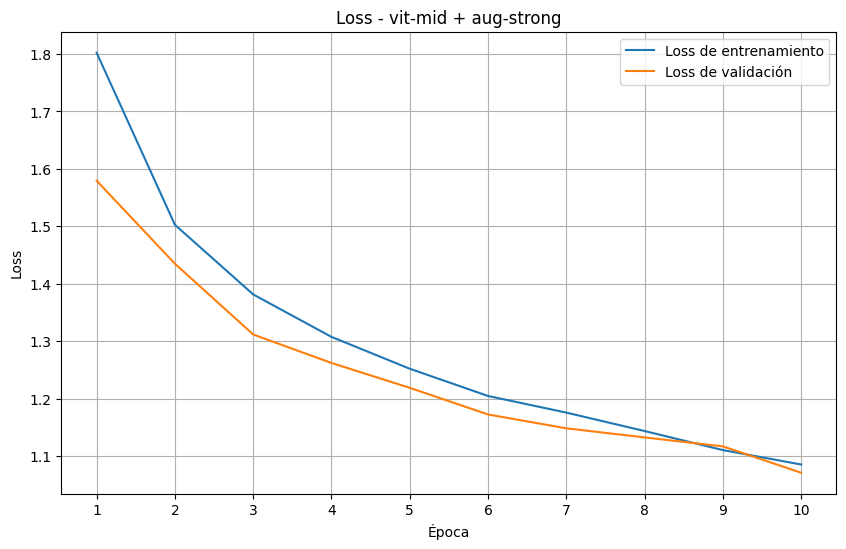

  0%|          | 0/79 [00:00<?, ?it/s]


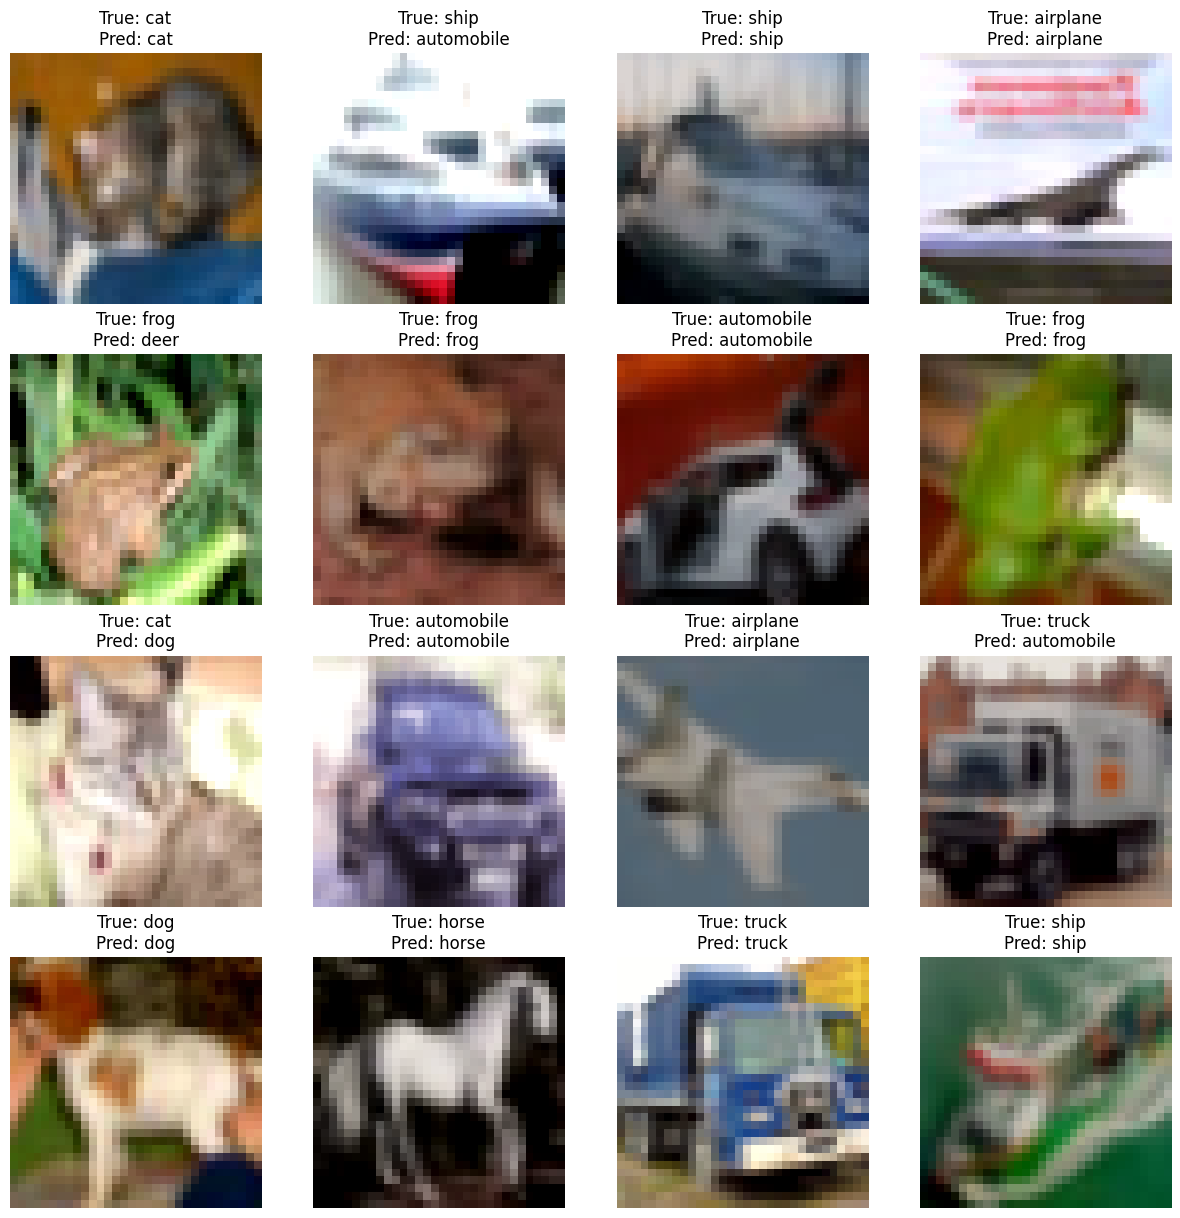


Entrenando vit-large con aug-light


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 4.23 millones
Epoch 1/10


val_loss 1.34433: 100%|██████████| 79/79 [02:09<00:00,  1.64s/it]


Epoch 2/10


val_loss 0.97195: 100%|██████████| 79/79 [02:07<00:00,  1.61s/it]


Epoch 3/10


val_loss 0.98011: 100%|██████████| 79/79 [02:08<00:00,  1.63s/it]


Epoch 4/10


val_loss 0.88704: 100%|██████████| 79/79 [02:06<00:00,  1.61s/it]


Epoch 5/10


val_loss 0.77241: 100%|██████████| 79/79 [02:06<00:00,  1.61s/it]


Epoch 6/10


val_loss 0.83019: 100%|██████████| 79/79 [02:07<00:00,  1.62s/it]


Epoch 7/10


val_loss 0.64692: 100%|██████████| 79/79 [02:07<00:00,  1.62s/it]


Epoch 8/10


val_loss 0.68686: 100%|██████████| 79/79 [02:07<00:00,  1.61s/it]


Epoch 9/10


val_loss 0.54226: 100%|██████████| 79/79 [02:07<00:00,  1.61s/it]


Epoch 10/10


100%|██████████| 79/79 [02:07<00:00,  1.62s/it]


- Accuracy: 0.69 
- Precision: 0.70 
- Recall: 0.69 
- F1-Score: 0.69
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-large_aug-light.png


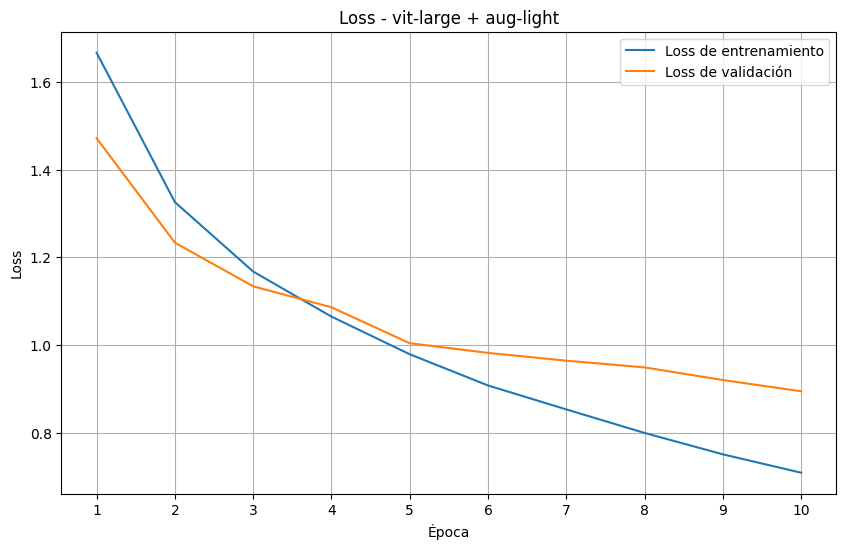

  0%|          | 0/79 [00:01<?, ?it/s]


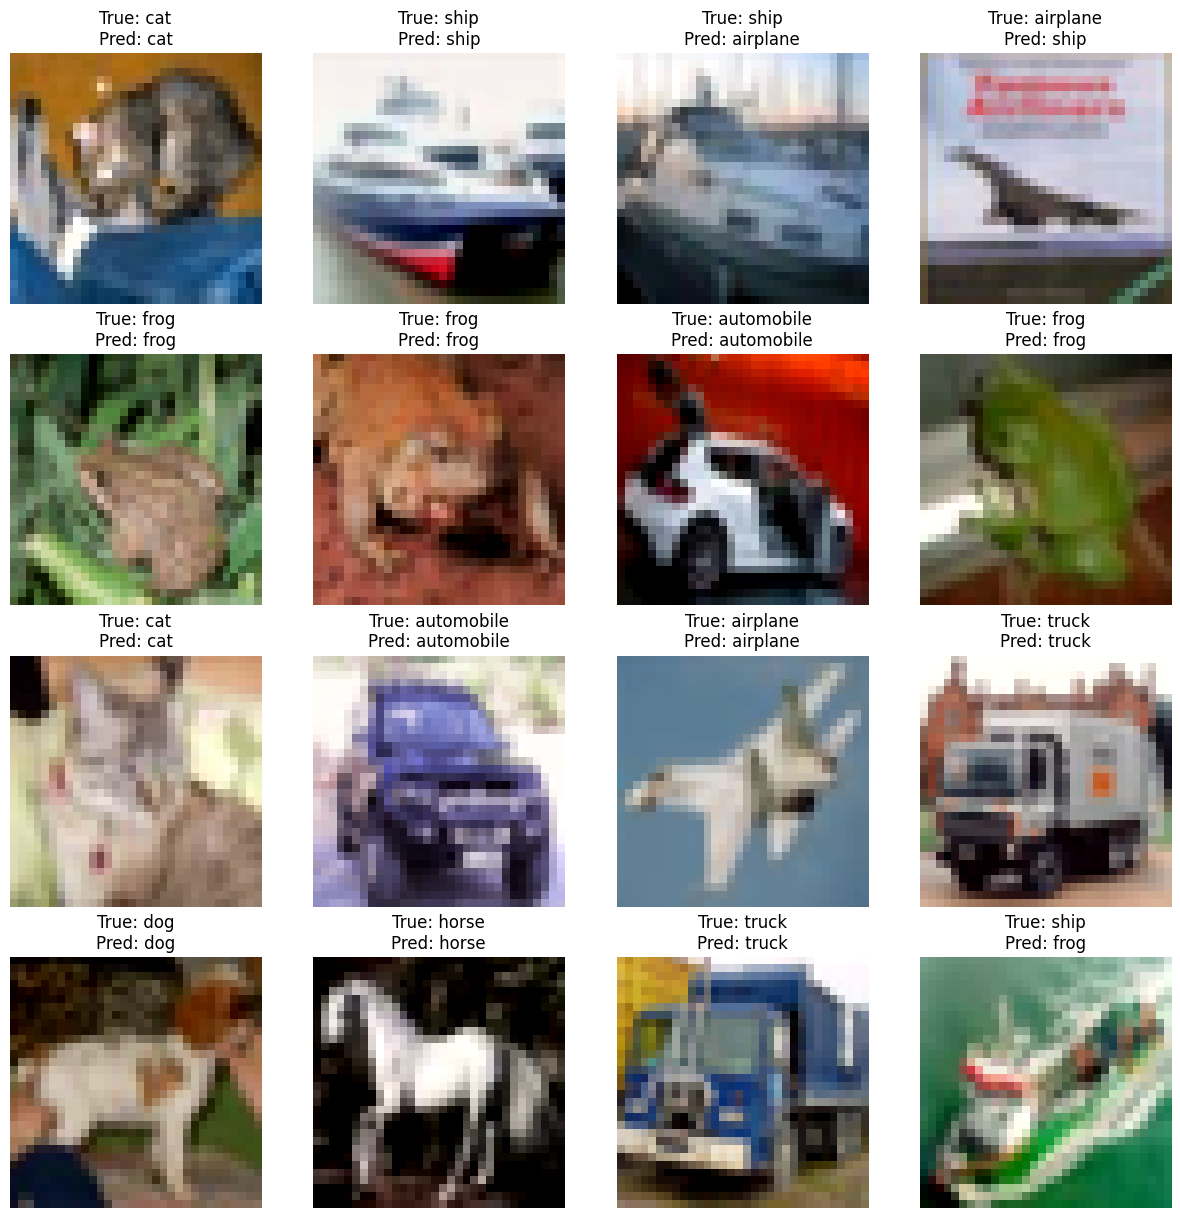


Entrenando vit-large con aug-strong


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 4.23 millones
Epoch 1/10


val_loss 1.21797: 100%|██████████| 79/79 [02:12<00:00,  1.68s/it]


Epoch 2/10


val_loss 1.06174: 100%|██████████| 79/79 [02:12<00:00,  1.68s/it]


Epoch 3/10


val_loss 1.13968: 100%|██████████| 79/79 [02:36<00:00,  1.98s/it]


Epoch 4/10


val_loss 0.97772: 100%|██████████| 79/79 [02:35<00:00,  1.97s/it]


Epoch 5/10


val_loss 1.21655: 100%|██████████| 79/79 [02:32<00:00,  1.94s/it]


Epoch 6/10


val_loss 1.05824: 100%|██████████| 79/79 [02:52<00:00,  2.19s/it]


Epoch 7/10


val_loss 0.84706: 100%|██████████| 79/79 [02:15<00:00,  1.71s/it]


Epoch 8/10


val_loss 0.87208: 100%|██████████| 79/79 [02:18<00:00,  1.75s/it]


Epoch 9/10


val_loss 0.90540: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Epoch 10/10


100%|██████████| 79/79 [02:20<00:00,  1.78s/it]


- Accuracy: 0.68 
- Precision: 0.68 
- Recall: 0.68 
- F1-Score: 0.67
Resultados guardados en: results/results.csv
Gráfico guardado en: results/learning_curve_vit-large_aug-strong.png


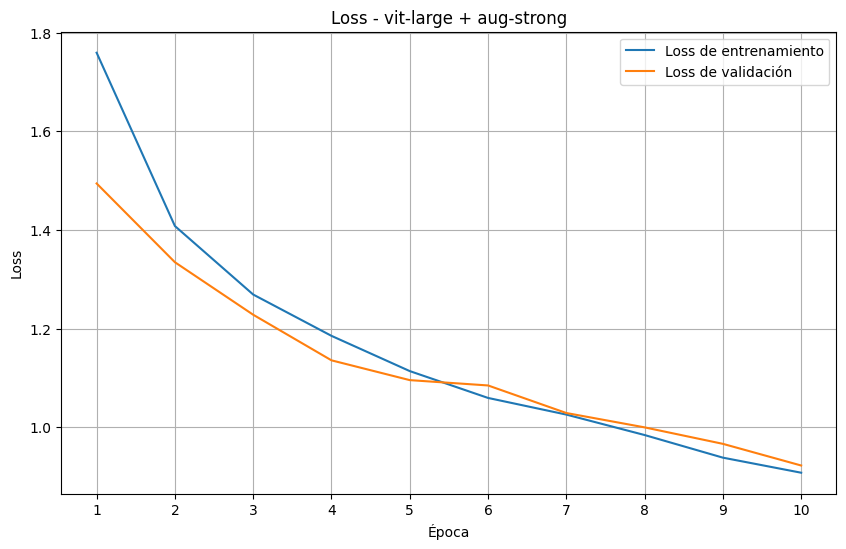

  0%|          | 0/79 [00:02<?, ?it/s]


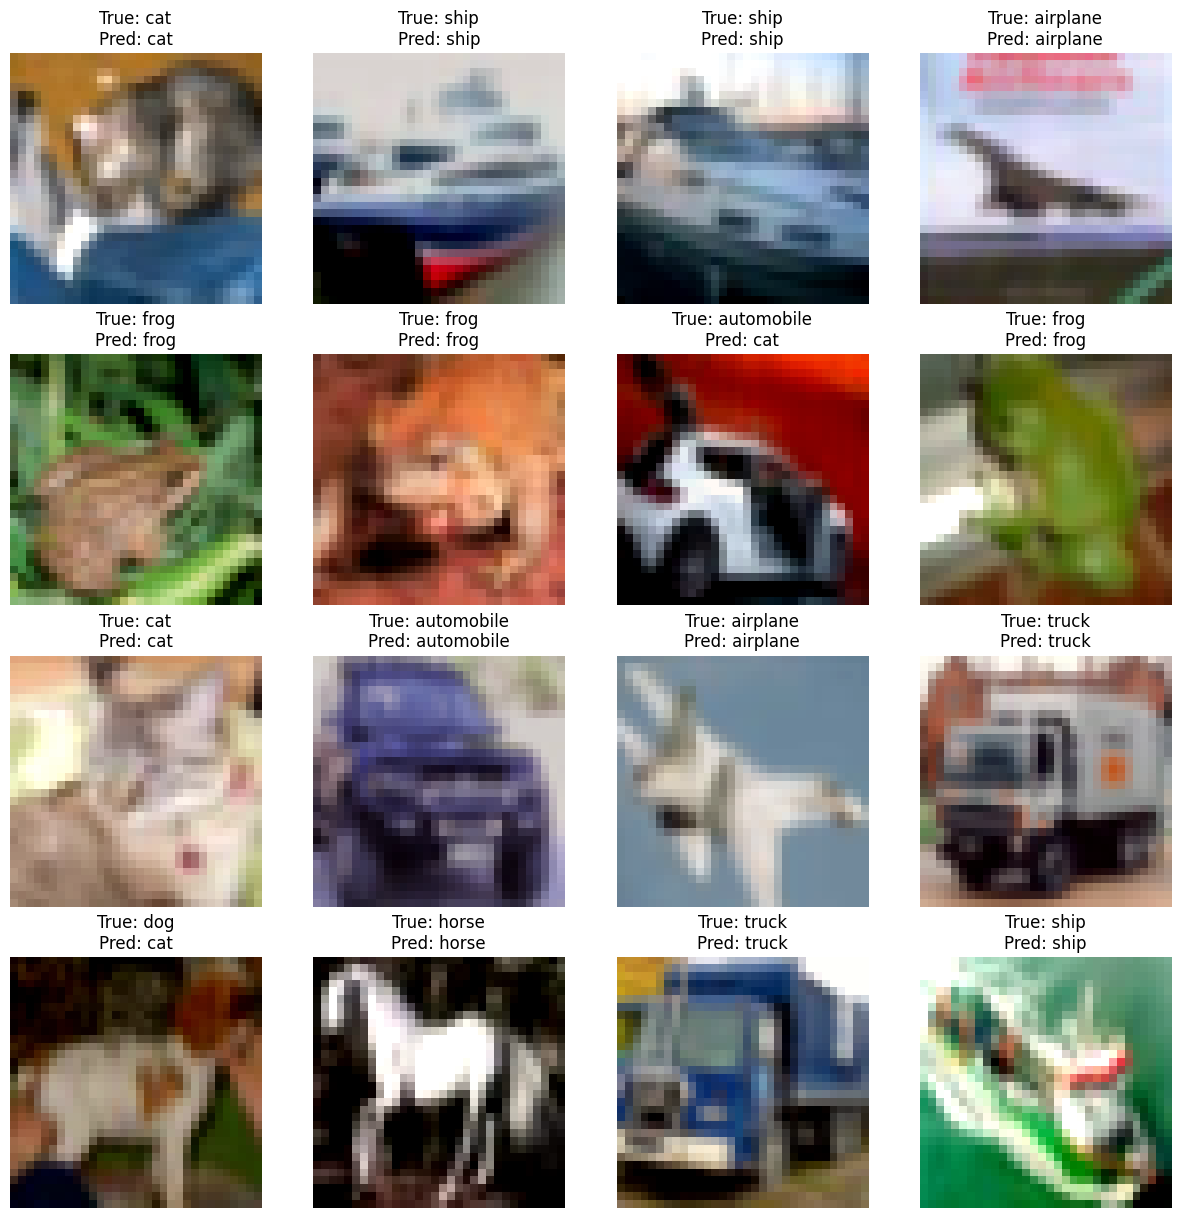

In [ ]:
from trainer import EarlyStopping

num_epochs = 10
results_path = "results/results.csv"

if not os.path.exists(results_path):
    pd.DataFrame(columns=[
        "Model", "Augmentation", "Accuracy", "Precision", "Recall", "F1-score", "Epochs", "Params"
    ]).to_csv(results_path, index=False)

for model_conf in model_configs:
    for aug_name, aug in aug_configs.items():
        print(f"\nEntrenando {model_conf['name']} con {aug_name}")
        train_losses = []
        val_losses = []

        # Carga de datos
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=aug)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=aug)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

        # Inicialización del modelo
        model = VisionTransformer(**model_conf["params"], 
                                  in_channels=3, 
                                  num_classes=10, 
                                  batch_first=True).to(device)

        try:
            model = torch.compile(model)
        except Exception as e:
            print("Se produjo error durante la compilación:", e)

        # Definimos funciones de loss y optimizador
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=3e-4)
        scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

        print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))
        trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
        
        early_stopping = EarlyStopping(patience=3, min_delta=0.001, restore_best_weights=True)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_loss = trainer.train_model(use_amp=False)
            val_loss = trainer.eval_model()

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if early_stopping(model, val_loss):
                print(f"Early stopping activado en epoch {epoch+1}")
                break

        # Métricas 
        acc, prec, rec, f1 = evaluate_model(model, test_loader)
        print(f"- Accuracy: {acc:.2f} \n- Precision: {prec:.2f} \n- Recall: {rec:.2f} \n- F1-Score: {f1:.2f}")

        # Guardar resultados en CSV
        row = {
            "Model": model_conf["name"],
            "Augmentation": aug_name,
            "Accuracy": round(acc, 4),
            "Precision": round(prec, 4),
            "Recall": round(rec, 4),
            "F1-score": round(f1, 4),
            "Epochs": num_epochs,
            "Params": str(model_conf["params"])
        }

        df = pd.read_csv(results_path)
        if df.empty or df.columns.isnull().all():
            df = pd.DataFrame(columns=[
                "Model", "Augmentation", "Accuracy", "Precision", "Recall", "F1-score", "Epochs", "Params"
            ])
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        df.to_csv(results_path, index=False)
        print("Resultados guardados en:", results_path)

        # Guardar imagen de la curva de aprendizaje
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label='Loss de entrenamiento')
        plt.plot(epochs, val_losses, label='Loss de validación')
        plt.title(f'Loss - {model_conf["name"]} + {aug_name}')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.xticks(epochs)
        plt.grid(True)

        curve_path = f"results/learning_curve_{model_conf['name']}_{aug_name}.png"
        plt.savefig(curve_path)
        print(f"Gráfico guardado en: {curve_path}")
        plt.show()

        # Visualización de predicciones
        class_names = train_dataset.classes
        visualize_classification(model, test_loader, class_names, num_images=16)
        plt.show()

Voy a entrenar la arquitectura **ViT-mid con aug-light** durante 20 epocas más (con early stopping), porque logró un buen equilibrio entre performance (F1-score alto y estable) y eficiencia computacional, siendo mucho más rápido que ViT-large y claramente superior a ViT-small tras solo 10 épocas en CPU.


Entrenando vit-mid con aug-light


/home/tmonreal/Desktop/Vision_Transformers/vision-transformers/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Número de parámetros: 0.80 millones
Epoch 1/30


val_loss 1.28124: 100%|██████████| 79/79 [00:40<00:00,  1.93it/s]


Epoch 2/30


val_loss 1.36477: 100%|██████████| 79/79 [00:44<00:00,  1.77it/s]


Epoch 3/30


val_loss 1.21054: 100%|██████████| 79/79 [00:46<00:00,  1.72it/s]


Epoch 4/30


val_loss 0.96139: 100%|██████████| 79/79 [00:44<00:00,  1.78it/s]


Epoch 5/30


val_loss 1.06957: 100%|██████████| 79/79 [00:40<00:00,  1.96it/s]


Epoch 6/30


val_loss 1.03839: 100%|██████████| 79/79 [00:48<00:00,  1.64it/s]


Epoch 7/30


val_loss 0.91677: 100%|██████████| 79/79 [00:34<00:00,  2.30it/s]


Epoch 8/30


val_loss 1.00732: 100%|██████████| 79/79 [00:40<00:00,  1.94it/s]


Epoch 9/30


val_loss 1.17463: 100%|██████████| 79/79 [00:44<00:00,  1.78it/s]


Epoch 10/30


val_loss 1.14053: 100%|██████████| 79/79 [00:33<00:00,  2.34it/s]


Epoch 11/30


val_loss 0.76133: 100%|██████████| 79/79 [00:40<00:00,  1.97it/s]


Epoch 12/30


val_loss 0.94740: 100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 13/30


val_loss 1.01760: 100%|██████████| 79/79 [00:33<00:00,  2.38it/s]


Epoch 14/30


val_loss 0.69171: 100%|██████████| 79/79 [00:33<00:00,  2.35it/s]


Epoch 15/30


val_loss 0.71088: 100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 16/30


val_loss 0.76034: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 17/30


val_loss 0.64103: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 18/30


val_loss 0.78834: 100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


Epoch 19/30


val_loss 0.70971: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Early stopping activado en epoch 19


100%|██████████| 79/79 [00:31<00:00,  2.47it/s]


- Accuracy: 0.66 
- Precision: 0.66 
- Recall: 0.66 
- F1-Score: 0.66
Resultados guardados en: results/results.csv
Modelo guardado en: results/vit-mid_aug-light.pth
Gráfico guardado en: results/learning_curve_vit-mid_aug-light.png


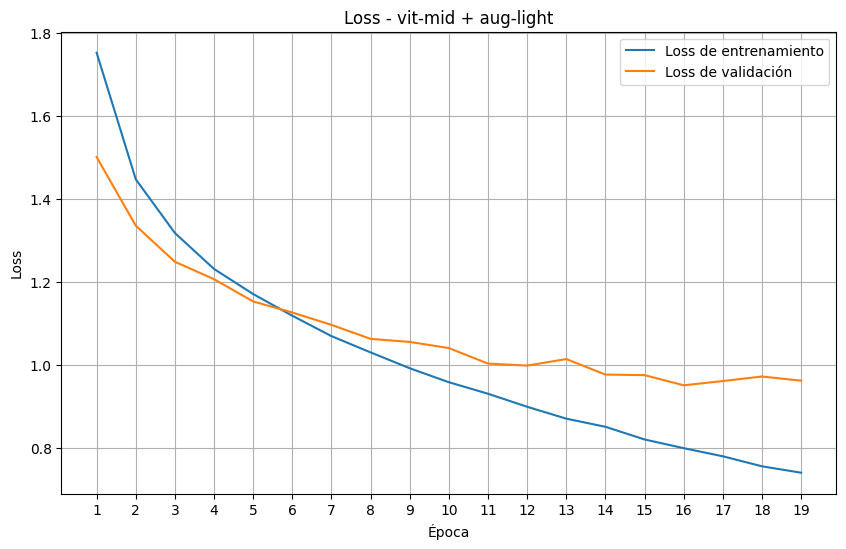

  0%|          | 0/79 [00:00<?, ?it/s]


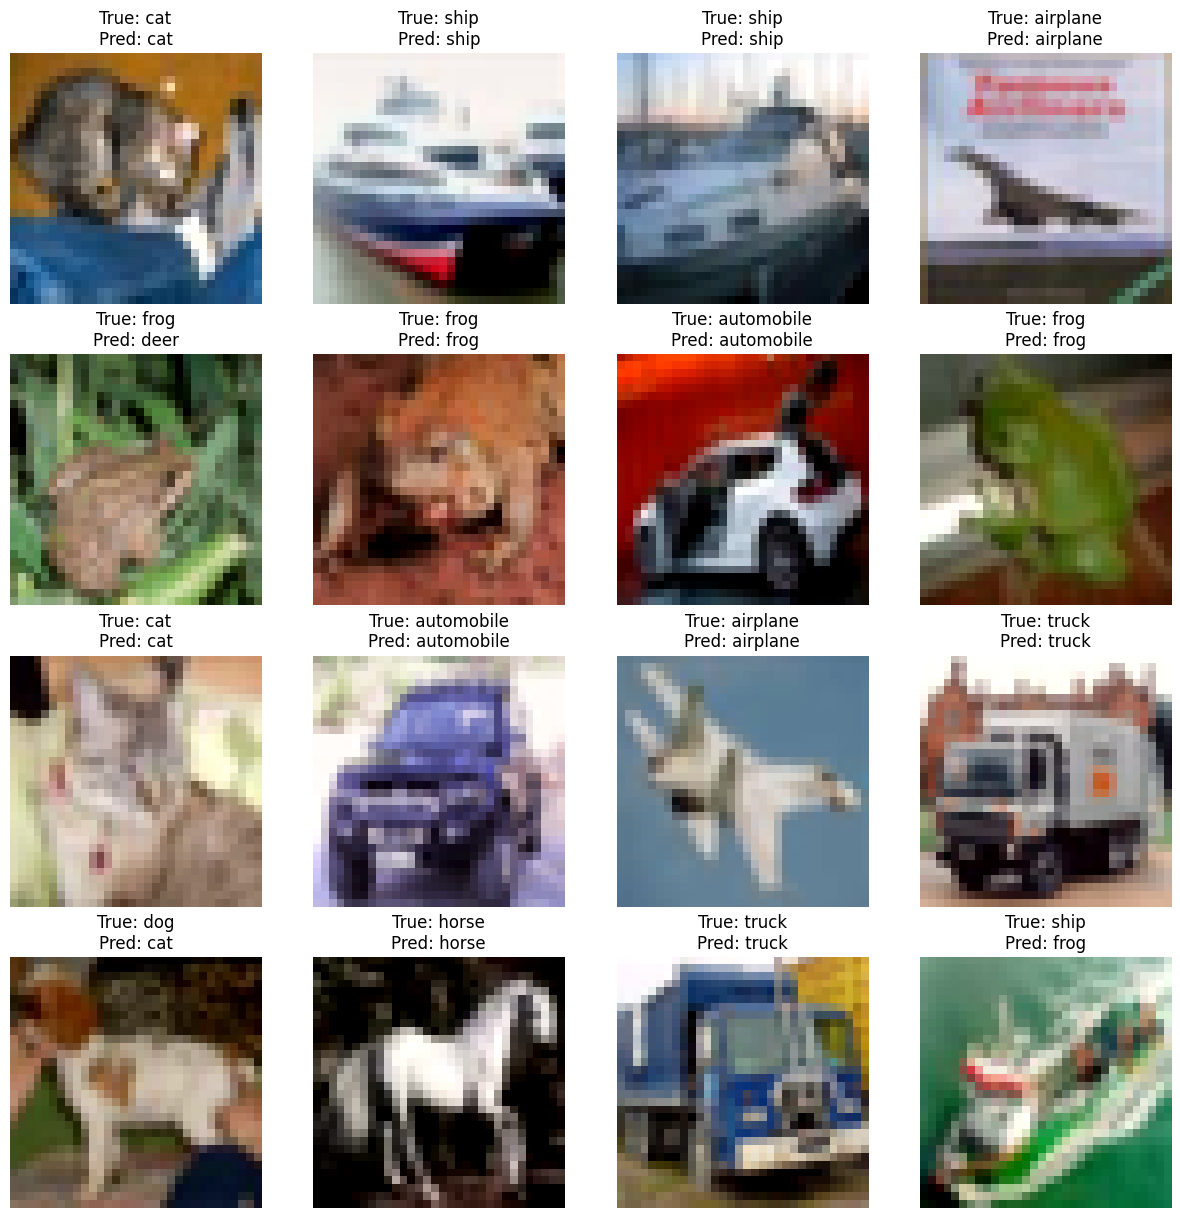

In [20]:
num_epochs = 30
results_path = "results/results.csv"

if not os.path.exists(results_path):
    pd.DataFrame(columns=[
        "Model", "Augmentation", "Accuracy", "Precision", "Recall", "F1-score", "Epochs", "Params"
    ]).to_csv(results_path, index=False)

# Selección específica
model_conf = next(conf for conf in model_configs if conf["name"] == "vit-mid")
aug_name = "aug-light"
aug = aug_configs[aug_name]

print(f"\nEntrenando {model_conf['name']} con {aug_name}")
train_losses = []
val_losses = []

# Carga de datos
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=aug)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=aug)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Inicialización del modelo
model = VisionTransformer(**model_conf["params"],
                          in_channels=3,
                          num_classes=10,
                          batch_first=True).to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

early_stopping = EarlyStopping(patience=3, min_delta=0.001, restore_best_weights=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = trainer.train_model(use_amp=False)
    val_loss = trainer.eval_model()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if early_stopping(model, val_loss):
        print(f"Early stopping activado en epoch {epoch+1}")
        break

# Métricas
acc, prec, rec, f1 = evaluate_model(model, test_loader)
print(f"- Accuracy: {acc:.2f} \n- Precision: {prec:.2f} \n- Recall: {rec:.2f} \n- F1-Score: {f1:.2f}")

# Guardar resultados en CSV
row = {
    "Model": model_conf["name"],
    "Augmentation": aug_name,
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1-score": round(f1, 4),
    "Epochs": num_epochs,
    "Params": str(model_conf["params"])
}

df = pd.read_csv(results_path)
if df.empty or df.columns.isnull().all():
    df = pd.DataFrame(columns=[
        "Model", "Augmentation", "Accuracy", "Precision", "Recall", "F1-score", "Epochs", "Params"
    ])
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df.to_csv(results_path, index=False)
print("Resultados guardados en:", results_path)

# Guardar modelo
model_path = "results/vit-mid_aug-light.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en: {model_path}")

# Guardar imagen de la curva de aprendizaje
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Loss de entrenamiento')
plt.plot(epochs, val_losses, label='Loss de validación')
plt.title(f'Loss - {model_conf["name"]} + {aug_name}')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.grid(True)

curve_path = f"results/learning_curve_{model_conf['name']}_{aug_name}.png"
plt.savefig(curve_path)
print(f"Gráfico guardado en: {curve_path}")
plt.show()

# Visualización de predicciones
class_names = train_dataset.classes
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

La combinación de un ViT de tamaño intermedio con una augmento de datos pequeño ofrece un balance ideal para entrenar en CPU si el tiempo es limitado (tarda ~ 4-6h más que vit-small). 

Obviamente, si se entrenara en GPU o se reduciera el tamaño del dataset, se podría probar extender a 30+ epochs o aplicar cosine scheduler para afinar un poco más.